<a href="https://colab.research.google.com/github/ToyTeX/Notebooks/blob/main/compact4thOrder_LUipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We solve the BVP by applying a compact 4th-order finite-difference scheme, using a tridiagonal LU method implemented with vectors.

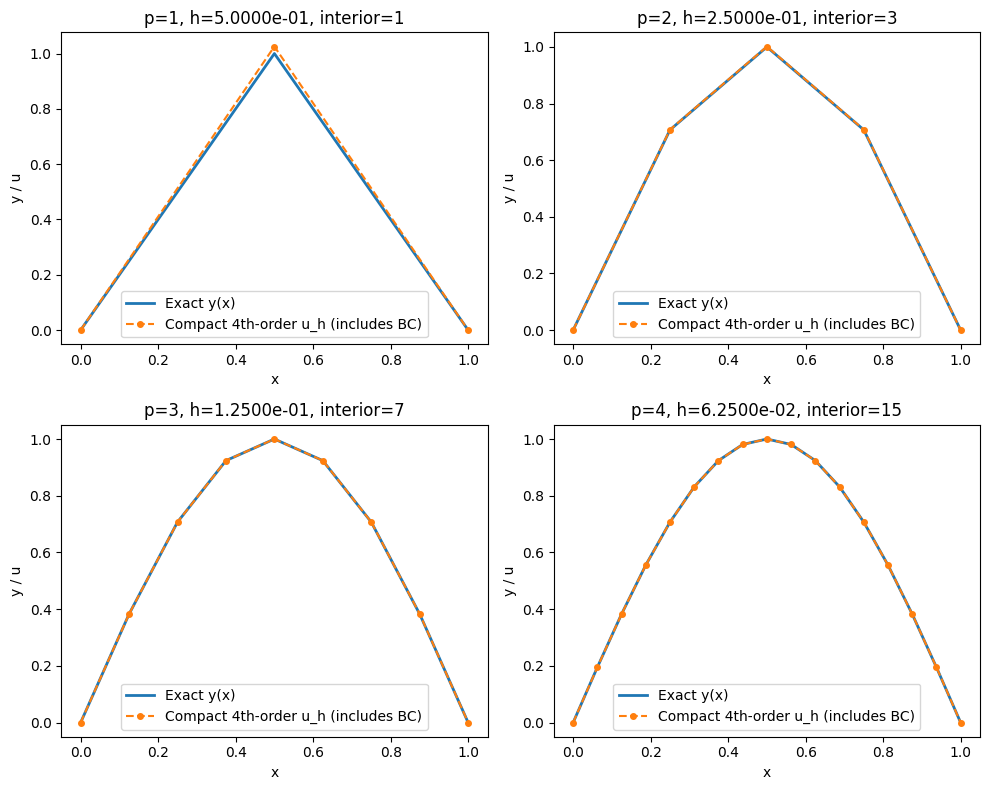

Compact 4th-order scheme results (p=1..20):


,h,||u_h - y||_inf,||u_h - y||_inf / h^4
0,5.000000e-01,2.543438e-02,4.069500e-01
1,2.500000e-01,1.475369e-03,3.776944e-01
2,1.250000e-01,9.052619e-05,3.707953e-01
3,6.250000e-02,5.631951e-06,3.690956e-01
4,3.125000e-02,3.515932e-07,3.686722e-01
5,1.562500e-02,2.196836e-08,3.685679e-01
6,7.812500e-03,1.373251e-09,3.686292e-01
7,3.906250e-03,8.715428e-11,3.743248e-01
8,1.953125e-03,1.047884e-11,7.201004e-01
9,9.765625e-04,2.166201e-11,2.381763e+01


Smallest p in 1..20 with ||u-y||_inf < 1e-3 for 4th-order: p=3, h=1.250000e-01, error=9.053e-05
\nSecond-order scheme results (p=1..20):


,h,||u_h - y||_inf,||u_h - y||_inf / h^2
0,5.000000e-01,2.077338e-01,8.309353e-01
1,2.500000e-01,4.791684e-02,7.666694e-01
2,1.250000e-01,1.174529e-02,7.516984e-01
3,6.250000e-02,2.921955e-03,7.480206e-01
4,3.125000e-02,7.295949e-04,7.471051e-01
5,1.562500e-02,1.823429e-04,7.468765e-01
6,7.812500e-03,4.558224e-05,7.468194e-01
7,3.906250e-03,1.139534e-05,7.468051e-01
8,1.953125e-03,2.848822e-06,7.468015e-01
9,9.765625e-04,7.122045e-07,7.468006e-01


Smallest p in 1..20 with ||u-y||_inf < 1e-3 for 2nd-order: p=5, h=3.125000e-02, error=7.296e-04
\nConvergence diagnostic for compact 4th-order (p=1..8):


,p,h,error_inf,error_inf/h^4
0,1,5.000000e-01,2.543438e-02,4.069500e-01
1,2,2.500000e-01,1.475369e-03,3.776944e-01
2,3,1.250000e-01,9.052619e-05,3.707953e-01
3,4,6.250000e-02,5.631951e-06,3.690956e-01
4,5,3.125000e-02,3.515932e-07,3.686722e-01
5,6,1.562500e-02,2.196836e-08,3.685679e-01
6,7,7.812500e-03,1.373251e-09,3.686292e-01
7,8,3.906250e-03,8.715428e-11,3.743248e-01


In [ ]:

# Compact 4th-order finite-difference BVP solver notebook cell
# Solves: -y''(x) + d(x) y(x) = f(x), 0<x<1, y(0)=y(1)=0
# Compact 4th-order scheme and 2nd-order central scheme for comparison.
# Uses a vector (Thomas) tridiagonal LU solver (no full matrices).
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

# -- Exact solution and coefficient (manufactured solution) ------------------
def y_exact(x):
    return np.sin(pi * x)

def d_coeff(x):
    return np.ones_like(x)  # d(x)=1 in this manufactured example

def f_for_exact(x):
    return (pi**2 + 1.0) * np.sin(pi * x)

# -- Thomas tridiagonal solver (vectorized, in-place style but copies inputs) --
def thomas_solve(a, b, c, rhs):
    n = len(b)
    # Work on copies
    ac = a.copy()
    bc = b.copy()
    cc = c.copy()
    rc = rhs.copy()
    # Forward elimination
    for k in range(1, n):
        m = ac[k] / bc[k-1]
        bc[k] = bc[k] - m * cc[k-1]
        rc[k] = rc[k] - m * rc[k-1]
    # Back substitution
    u = np.zeros(n)
    u[-1] = rc[-1] / bc[-1]
    for k in range(n-2, -1, -1):
        u[k] = (rc[k] - cc[k] * u[k+1]) / bc[k]
    return u

# -- Compact 4th-order scheme assembly and solve --------------------------------
def solve_compact_4th(p):
    h = 1.0 / (2**p)
    m = int(1.0 / h)
    n = m - 1  # number of interior unknowns
    x_all = np.linspace(0.0, 1.0, m+1)
    d_all = d_coeff(x_all)
    f_all = f_for_exact(x_all)
    # s_i = 1 - (h^2/12) d_i for interior i
    if n > 0:
        s = 1.0 - (h**2 / 12.0) * d_all[1:-1]  # length n
        b = 2.0 * s + (h**2) * d_all[1:-1]
        a = np.zeros(n)
        c = np.zeros(n)
        for k in range(n):
            if k >= 1:
                a[k] = - s[k]
            if k <= n - 2:
                c[k] = - s[k]
        # RHS: h^2*( f_i + (1/12)*(f_{i+1} - 2 f_i + f_{i-1}) )
        rhs = np.zeros(n)
        for k in range(n):
            i = k + 1
            rhs[k] = h**2 * ( f_all[i] + (1.0/12.0) * ( f_all[i+1] - 2.0*f_all[i] + f_all[i-1] ) )
        # Boundary contributions (Dirichlet y(0), y(1))
        y0 = y_exact(0.0)
        y1 = y_exact(1.0)
        if n >= 1:
            a1 = - s[0]   # coefficient of u_0 in first equation
            rhs[0] = rhs[0] - a1 * y0
            cn = - s[-1]  # coefficient of u_{n+1} in last equation
            rhs[-1] = rhs[-1] - cn * y1
        u_interior = thomas_solve(a, b, c, rhs) if n>0 else np.array([])
    else:
        # No interior points (degenerate grid)
        a = np.zeros(0); b = np.zeros(0); c = np.zeros(0); rhs = np.zeros(0)
        u_interior = np.array([])
    # Build full solution including boundaries
    u_full = np.zeros(m+1)
    u_full[0] = y_exact(0.0)
    u_full[-1] = y_exact(1.0)
    if n > 0:
        u_full[1:-1] = u_interior
    return x_all, u_full, h

# -- Standard 2nd-order central difference assembly and solve -------------------
def solve_second_order(p):
    h = 1.0 / (2**p)
    m = int(1.0 / h)
    n = m - 1
    x_all = np.linspace(0.0, 1.0, m+1)
    d_all = d_coeff(x_all)
    f_all = f_for_exact(x_all)
    if n > 0:
        a = np.zeros(n)
        c = np.zeros(n)
        b = np.zeros(n)
        for k in range(n):
            i = k + 1
            b[k] = 2.0 + h**2 * d_all[i]
            if k >= 1:
                a[k] = -1.0
            if k <= n - 2:
                c[k] = -1.0
        rhs = np.zeros(n)
        for k in range(n):
            i = k + 1
            rhs[k] = h**2 * f_all[i]
        # boundary
        y0 = y_exact(0.0)
        y1 = y_exact(1.0)
        if n >= 1:
            rhs[0] = rhs[0] - (-1.0)*y0
            rhs[-1] = rhs[-1] - (-1.0)*y1
        u_interior = thomas_solve(a, b, c, rhs)
    else:
        u_interior = np.array([])
    u_full = np.zeros(m+1)
    u_full[0] = y_exact(0.0)
    u_full[-1] = y_exact(1.0)
    if n>0:
        u_full[1:-1] = u_interior
    return x_all, u_full, h

# -- Part A: plots for p = 1..4 (compact 4th-order) ------------------------------
ps_plot = [1,2,3,4]
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
for idx, p in enumerate(ps_plot, 1):
    x, u, h = solve_compact_4th(p)
    plt.subplot(2,2,idx)
    plt.plot(x, y_exact(x), label='Exact y(x)', linewidth=2)
    plt.plot(x, u, label='Compact 4th-order u_h (includes BC)', linestyle='--', marker='o', markersize=4)
    plt.title(f'p={p}, h={h:.4e}, interior={len(x)-2}')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y / u')
plt.tight_layout()
plt.show()

# -- Part B: p = 1..20 error table for compact 4th-order -------------------------
rows = []
ps = list(range(1,21))
for p in ps:
    x4, u4, h = solve_compact_4th(p)
    yvals = y_exact(x4)
    err_inf = np.max(np.abs(u4 - yvals))
    rows.append((h, err_inf, err_inf / (h**4)))
import pandas as pd
df = pd.DataFrame(rows, columns=['h', '||u_h - y||_inf', '||u_h - y||_inf / h^4'])
pd.set_option('display.float_format', '{:.6e}'.format)
print('Compact 4th-order scheme results (p=1..20):')
display(df)

# smallest h (in p range) achieving error < 1e-3
achieved = [(ps[i], df.iloc[i,0], df.iloc[i,1]) for i in range(len(ps)) if df.iloc[i,1] < 1e-3]
if achieved:
    p_best, h_best, err_best = achieved[0]
    print(f"Smallest p in 1..20 with ||u-y||_inf < 1e-3 for 4th-order: p={p_best}, h={h_best:.6e}, error={err_best:.3e}")
else:
    print("No h within p=1..20 achieved error < 1e-3 for the 4th-order scheme.")

# -- Part C: second-order comparison table and threshold ------------------------
rows2 = []
for p in ps:
    x2, u2, h2 = solve_second_order(p)
    yvals = y_exact(x2)
    err2 = np.max(np.abs(u2 - yvals))
    rows2.append((h2, err2, err2 / (h2**2)))
df2 = pd.DataFrame(rows2, columns=['h', '||u_h - y||_inf', '||u_h - y||_inf / h^2'])
print('\\nSecond-order scheme results (p=1..20):')
display(df2)

achieved2 = [(ps[i], df2.iloc[i,0], df2.iloc[i,1]) for i in range(len(ps)) if df2.iloc[i,1] < 1e-3]
if achieved2:
    p2_best, h2_best, err2_best = achieved2[0]
    print(f"Smallest p in 1..20 with ||u-y||_inf < 1e-3 for 2nd-order: p={p2_best}, h={h2_best:.6e}, error={err2_best:.3e}")
else:
    print("No h within p=1..20 achieved error < 1e-3 for the 2nd-order scheme.")

# -- Convergence diagnostic (p=1..8) for compact 4th-order ----------------------
ps_check = list(range(1,9))
conv_rows = []
for p in ps_check:
    x, u, h = solve_compact_4th(p)
    err = np.max(np.abs(u - y_exact(x)))
    conv_rows.append((p, h, err, err / (h**4)))
conv_df = pd.DataFrame(conv_rows, columns=['p', 'h', 'error_inf', 'error_inf/h^4'])
print('\\nConvergence diagnostic for compact 4th-order (p=1..8):')
display(conv_df)






*   Column 1 is the mesh spacing, a discretization parameter.  As $p$ increases by 1,  $h$  halves and the number of interior unknowns about doubles.
*   Column 2 is the maximum pointwise difference between the numerical solution and the exact solution on the grid (including boundary points)- the infinity norm error.  The error decreases and then starts increasing slightly (round-off error).     
- Column 3 is the scaled error. The scaled values eventually settle to an approximately constant number, which agrees with 4th order convergence.  It is signature of O(h^2) behavior.  

The value 1/8 (at p=3) for $h$  gives the infinity norm error below 10^-3 for 4th order and the value 3.125000e-02 (at p=5) for 2nd order, so the 4th-order method reaches the target accuracy with a larger $h$ (coarser grid) than the second order method adn can save some computational cost.  

